In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_score
from data_processing import (
    getDatasets,
    create_statistical_features,
    perform_kmeans_clustering
)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load datasets
datasets = getDatasets()

# Road surface columns
surface_cols = ['dirt_road', 'cobblestone_road', 'asphalt_road']

# Combine left, right data and labels for each PVS
combined_datasets = pd.DataFrame({
    'pvs': list(datasets.keys()),
    'dataframe': [
        pd.concat([
            datasets[pvs_key]['data_left'].add_suffix('_left'),
            datasets[pvs_key]['data_right'].add_suffix('_right'),
            datasets[pvs_key]['data_labels'][surface_cols].idxmax(axis=1).rename('road_surface')
        ], axis=1)
        for pvs_key in datasets.keys()
    ]
})


In [3]:
# Encode road_surface labels for all PVS dataframes
surface_mapping = {
    'asphalt_road': 0,
    'cobblestone_road': 1,
    'dirt_road': 2
}

for df in combined_datasets['dataframe']:
    df['road_surface'] = df['road_surface'].map(surface_mapping).astype('int8')

In [4]:
# Normalize raw sensor data (NO statistical features)
for i, row in combined_datasets.iterrows():
    df = row['dataframe']
    
    # Keep only acc, gyro, mag, and speed sensor columns (plus label)
    allowed_keywords = ('acc', 'gyro', 'mag', 'speed')
    sensor_cols = [col for col in df.columns if col != 'road_surface' and any(k in col for k in allowed_keywords)]
    road_surface = df['road_surface']
    df = df[sensor_cols]
    
    # Normalize raw sensor data
    scaler = StandardScaler()
    df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    df['road_surface'] = road_surface
    
    # Update the dataframe in the combined_datasets
    combined_datasets.at[i, 'dataframe'] = df

print(f"Number of sensor features: {len(sensor_cols)}")
print(f"Sample data shape: {combined_datasets.dataframe[0].shape}")
combined_datasets.dataframe[0].head()

/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_20102/104183700.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_20102/104183700.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['road_surface'] = road_surface
/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_20102/104183700.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

Number of sensor features: 50
Sample data shape: (144036, 51)


/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_20102/104183700.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_20102/104183700.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['road_surface'] = road_surface
/var/folders/6s/m9t5x_x135n5fwsph2741ffw0000gn/T/ipykernel_20102/104183700.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,acc_x_dashboard_left,acc_y_dashboard_left,acc_z_dashboard_left,acc_x_above_suspension_left,acc_y_above_suspension_left,acc_z_above_suspension_left,acc_x_below_suspension_left,acc_y_below_suspension_left,acc_z_below_suspension_left,gyro_x_dashboard_left,...,gyro_y_below_suspension_right,gyro_z_below_suspension_right,mag_x_dashboard_right,mag_y_dashboard_right,mag_z_dashboard_right,mag_x_above_suspension_right,mag_y_above_suspension_right,mag_z_above_suspension_right,speed_right,road_surface
0,0.383223,0.078733,0.040739,0.332384,0.100222,-0.010061,0.164323,0.012596,0.001246,-0.011752,...,-0.009069,-0.002069,1.242380,1.128201,-0.620882,3.327310,2.010413,2.157061,-1.232546,0
1,0.402893,0.083051,0.028323,0.374134,0.111658,-0.049789,0.164323,0.016736,0.009206,0.012572,...,-0.003255,-0.012149,1.248993,1.204021,-0.010420,3.327310,1.858613,2.185797,-1.232546,0
2,0.414866,0.085519,0.007412,0.298055,0.106757,0.002030,0.152840,0.023175,0.016584,0.047322,...,-0.008238,0.000451,1.136577,0.998224,-0.132512,3.244554,1.850179,2.200165,-1.232546,0
3,0.387499,0.076882,0.016560,0.322178,0.139432,-0.030213,0.154116,0.012596,0.013866,-0.001327,...,-0.011560,-0.017189,1.163028,1.084875,-0.295302,3.244554,1.850179,2.200165,-1.232546,0
4,0.401182,0.074415,0.081908,0.345373,0.120644,-0.019273,0.154116,0.017886,0.012119,-0.022177,...,-0.014052,-0.017189,1.229155,1.019887,-0.051117,3.178349,1.985113,2.142693,-1.232546,0


In [5]:
# Split data into training and testing sets - use specific PVS for training
selected_dfs_train = [combined_datasets['dataframe'][i] for i in [0, 1, 2, 6, 7, 8]]
selected_dfs_test = [combined_datasets['dataframe'][i] for i in [3, 4, 5]]

print(f"Training PVS: {[0, 1, 2, 6, 7, 8]}")
print(f"Testing PVS: {[3, 4, 5]}")


Training PVS: [0, 1, 2, 6, 7, 8]
Testing PVS: [3, 4, 5]


In [6]:
# Create sliding windows from raw sensor data
def create_sliding_windows(df, window_size=100, stride=50):
    """
    Create sliding windows from raw sensor data.
    
    Args:
        df: DataFrame with sensor columns and 'road_surface' label
        window_size: Number of consecutive time steps per window
        stride: Step size for sliding window (overlap = window_size - stride)
    
    Returns:
        X: numpy array of shape (num_windows, num_features, window_size)
        y: numpy array of labels (num_windows,)
    """
    sensor_cols = [col for col in df.columns if col != 'road_surface']
    num_features = len(sensor_cols)
    
    X_windows = []
    y_windows = []
    
    # Slide window across the time series
    for start_idx in range(0, len(df) - window_size + 1, stride):
        end_idx = start_idx + window_size
        
        # Extract window of sensor data
        window = df[sensor_cols].iloc[start_idx:end_idx].values  # Shape: (window_size, num_features)
        
        # Transpose to (num_features, window_size) for Conv1d input
        window = window.T  # Shape: (num_features, window_size)
        
        # Get label for this window (use majority vote or middle point)
        labels_in_window = df['road_surface'].iloc[start_idx:end_idx]
        label = labels_in_window.mode()[0]  # Most common label in window
        
        X_windows.append(window)
        y_windows.append(label)
    
    return np.array(X_windows), np.array(y_windows)

# Create sliding windows for training data
window_size = 100  # 100 time steps per window
stride = 50        # 50% overlap

X_train_list = []
y_train_list = []

print("Creating sliding windows for training data...")
for df in selected_dfs_train:
    X_win, y_win = create_sliding_windows(df, window_size=window_size, stride=stride)
    X_train_list.append(X_win)
    y_train_list.append(y_win)
    print(f"  Created {len(X_win)} windows from {len(df)} samples")

X_train = np.vstack(X_train_list)
y_train = np.hstack(y_train_list)

# Create sliding windows for testing data
X_test_list = []
y_test_list = []

print("\nCreating sliding windows for testing data...")
for df in selected_dfs_test:
    X_win, y_win = create_sliding_windows(df, window_size=window_size, stride=stride)
    X_test_list.append(X_win)
    y_test_list.append(y_win)
    print(f"  Created {len(X_win)} windows from {len(df)} samples")

X_test = np.vstack(X_test_list)
y_test = np.hstack(y_test_list)

print(f"\nFinal shapes:")
print(f"X_train: {X_train.shape} (num_windows, num_features, window_size)")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print(f"\nTrain/test split: {len(X_train)/(len(X_train)+len(X_test))*100:.2f}% train, {len(X_test)/(len(X_train)+len(X_test))*100:.2f}% test")

# Final data format: (num_windows, num_features, window_size)

Creating sliding windows for training data...
  Created 2879 windows from 144036 samples
  Created 2492 windows from 124684 samples
  Created 2115 windows from 105816 samples
  Created 2569 windows from 128548 samples
  Created 2471 windows from 123618 samples
  Created 1830 windows from 91555 samples

Creating sliding windows for testing data...
  Created 2648 windows from 132492 samples
  Created 2676 windows from 133877 samples
  Created 1924 windows from 96279 samples

Final shapes:
X_train: (14356, 50, 100) (num_windows, num_features, window_size)
y_train: (14356,)
X_test: (7248, 50, 100)
y_test: (7248,)

Train/test split: 66.45% train, 33.55% test


### Create Convolutional Neural Network

In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)  # Already shape (num_windows, num_features, window_size)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

# Create DataLoaders - enable batch processing and shuffling
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {batch_size}")

X_train_tensor shape: torch.Size([14356, 50, 100])
y_train_tensor shape: torch.Size([14356])

DataLoaders created:
  Train batches: 57
  Test batches: 29
  Batch size: 256


In [8]:
# Define CNN architecture with larger kernels for temporal pattern detection
class RoadSurfaceNN(nn.Module):
    def __init__(self, input_channels, num_classes=3): 
        super(RoadSurfaceNN, self).__init__()
        
        # Block 1: Large kernel to capture 1 second of temporal patterns
        # kernel_size=100 looks at 100 consecutive time steps (1.0 second at 100Hz)
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=100, padding=50)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Downsample by 2x
        self.dropout1 = nn.Dropout(0.15)

        # Block 2: Medium kernel for 0.5 second patterns
        # kernel_size=50 looks at 50 time steps (0.5 seconds at 100Hz)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=50, padding=25)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Downsample by 2x
        self.dropout2 = nn.Dropout(0.2)

        # Block 3: Smaller kernel for 0.2 second fine-grained features
        # kernel_size=20 looks at 20 time steps (0.2 seconds at 100Hz)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=20, padding=10)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.25)
        
        # Global Average Pooling - reduces temporal dimension to 1
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)
        
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Total trainable parameters: {total_params:,}')
    
    def forward(self, x):
        # INPUT: x shape: (batch, num_features, window_size=100)
        
        # Block 1: Conv → ReLU → BatchNorm → MaxPool → Dropout
        x = self.conv1(x)      
        # Conv1d: in_channels=50, out_channels=64, kernel_size=100, padding=50
        # - Looks at ALL 50 input features together
        # - Slides kernel across 100 timesteps
        # - Creates 64 feature maps
        # Output: (batch, 64, 100) - padding maintains size
        x = self.relu1(x)       # (256, 64, 100) - apply ReLU activation
        x = self.bn1(x)         # (256, 64, 100) - batch normalization
        x = self.maxpool1(x)    # (batch, 64, 50) - downsampled by 2x
        x = self.dropout1(x)
        
        # Block 2: Conv → ReLU → BatchNorm → MaxPool → Dropout
        x = self.conv2(x)       # (batch, 128, 50)
        # Conv1d: in_channels=64, out_channels=128, kernel_size=50, padding=25
        # - Takes 64 feature maps from Block 1
        # - Creates 128 new feature maps
        # Output: (batch, 128, 50)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.maxpool2(x)    # (batch, 128, 25) - downsampled by 2x
        x = self.dropout2(x)

        # Block 3: Conv → ReLU → BatchNorm → Dropout
        x = self.conv3(x)       # (batch, 256, 25)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        
        # Global Average Pooling
        x = self.gap(x)         # (batch, 256, 1)
        x = x.squeeze(2)        # (batch, 256)
        
        # Fully connected layers
        x = self.fc1(x)         # (batch, 128)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc2(x)         # (batch, 3)
        
        return x

# Get number of input channels (features) from data
num_features = X_train_tensor.shape[1]
print(f"\nNumber of input features: {num_features}")

# Create model
cnn_model = RoadSurfaceNN(input_channels=num_features, num_classes=3)
# print(cnn_model)

print("\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
print(f"Input shape: (batch, {num_features}, 100)")
print(f"Conv1 kernel_size=100: Captures 100 time steps (1.0s @ 100Hz)")
print(f"Conv2 kernel_size=50:  Captures 50 time steps (0.5s @ 100Hz)")
print(f"Conv3 kernel_size=20:  Captures 20 time steps (0.2s @ 100Hz)")
print(f"MaxPool reduces temporal dimension: 100 → 50 → 25")
print(f"Global Average Pooling: 25 → 1")
print(f"Output: (batch, 3) - 3 road surface classes")
print("="*70)


Number of input features: 50
Total trainable parameters: 1,419,587

MODEL ARCHITECTURE SUMMARY
Input shape: (batch, 50, 100)
Conv1 kernel_size=100: Captures 100 time steps (1.0s @ 100Hz)
Conv2 kernel_size=50:  Captures 50 time steps (0.5s @ 100Hz)
Conv3 kernel_size=20:  Captures 20 time steps (0.2s @ 100Hz)
MaxPool reduces temporal dimension: 100 → 50 → 25
Global Average Pooling: 25 → 1
Output: (batch, 3) - 3 road surface classes


In PyTorch Conv1d:

- Input channels = number of parallel input streams (your 30 sensors)
- Temporal dimension = sequence length to convolve over (your 100 timesteps)
- Kernel size = how many consecutive timesteps to look at

This creates 64 filters, each of which:

- Looks at all 30 input channels simultaneously
- Slides a window of size 100 across the temporal dimension
- Produces one feature map (one of the 64 output channels)

### Summary

The (num_windows, num_features, window_size) format works perfectly with RoadSurfaceNN because:

- Batch dimension num_windows → Processed in parallel by GPU
- Feature dimension num_features=30 → Treated as input channels (like RGB), all processed together by each Conv1d filter
- Temporal dimension window_size=100 → Conv1d slides kernels along this dimension to detect temporal patterns

The network progressively:

- Increases feature complexity: 30 → 64 → 128 → 256 channels
- Reduces temporal resolution: 100 → 50 → 25 → 1 timesteps
- Extracts multi-scale patterns: 1.0s → 0.5s → 0.2s kernels
- Classifies: Final FC layers map 256 features → 3 road types

This is exactly analogous to how image CNNs work, but applied to 1D temporal sensor data instead of 2D spatial images!

In [9]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader): # Loop over each batch in the DataLoader
        inputs, labels = inputs.to(device), labels.to(device) # Move data to device

        optimizer.zero_grad()
        outputs = model(inputs) # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels) # Compute the loss between predicted outputs and true labels
        loss.backward() # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # Update model parameters based on computed gradients
        
        running_loss += loss.item() # loss.item() gets the scalar value of the loss tensor which is accumulated to running_loss for all batches in the epoch
        _, predicted = outputs.max(1) # Get the index of the max log-probability (predicted class)
        total += labels.size(0) # Update total number of samples
        correct += predicted.eq(labels).sum().item() # Update number of correct predictions
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    print(f'Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    """Test the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader) # Average loss over all batches
    test_acc = 100. * correct / total # Accuracy percentage
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    return test_loss, test_acc

def main(model, epochs=10):
    """Simplified main function - uses global variables for data loaders etc."""
    device = torch.device('mps')

    # Move model to device
    model.to(device)

    # Create optimizer and criterion AFTER moving model
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        print('-' * 50)
    
    print('Training completed!')
    return model

# To start training, run:
trained_face_model = main(cnn_model, epochs=30)

Epoch 1: Train Loss: 0.3504, Train Acc: 86.21%
Test Loss: 0.4269, Test Acc: 82.93%
--------------------------------------------------
Epoch 2: Train Loss: 0.2163, Train Acc: 91.80%
Test Loss: 0.3057, Test Acc: 87.68%
--------------------------------------------------
Epoch 3: Train Loss: 0.1628, Train Acc: 93.65%
Test Loss: 0.3764, Test Acc: 87.93%
--------------------------------------------------
Epoch 4: Train Loss: 0.1098, Train Acc: 95.78%
Test Loss: 0.3845, Test Acc: 87.17%
--------------------------------------------------
Epoch 5: Train Loss: 0.1369, Train Acc: 94.98%
Test Loss: 0.3882, Test Acc: 89.18%
--------------------------------------------------
Epoch 6: Train Loss: 0.0817, Train Acc: 97.04%
Test Loss: 0.3737, Test Acc: 89.35%
--------------------------------------------------
Epoch 7: Train Loss: 0.0722, Train Acc: 97.27%
Test Loss: 0.4176, Test Acc: 88.56%
--------------------------------------------------
Epoch 8: Train Loss: 0.0561, Train Acc: 97.79%
Test Loss: 0.43


Confusion Matrix: Road Surface Classification
                |                Predicted                
         Actual |   Asphalt    Cobblestone      Dirt    
------------------------------------------------------------
        Asphalt |     2843          78           12     
    Cobblestone |      18          1833         296     
           Dirt |      13          353          1802    

Overall Accuracy: 0.8938 (89.38%)
Total Test Samples: 7248
Correct Predictions: 6478

Per-Class Metrics:
------------------------------------------------------------
Class           Precision    Recall       F1-Score    
------------------------------------------------------------
Asphalt         0.989        0.969        0.979       
Cobblestone     0.810        0.854        0.831       
Dirt            0.854        0.831        0.842       


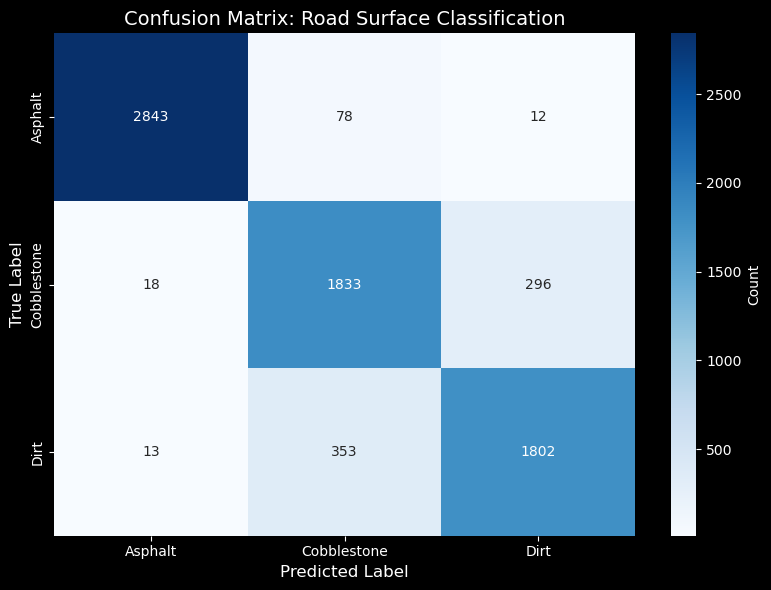


Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Asphalt       0.99      0.97      0.98      2933
 Cobblestone       0.81      0.85      0.83      2147
        Dirt       0.85      0.83      0.84      2168

    accuracy                           0.89      7248
   macro avg       0.88      0.88      0.88      7248
weighted avg       0.90      0.89      0.89      7248



In [10]:
# Generate confusion matrix for road surface classification
device = torch.device('mps')

# Road surface classes
surface_classes = ['Asphalt', 'Cobblestone', 'Dirt']

# Collect all predictions and true labels
all_predictions = []
all_labels = []

cnn_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_model(inputs)
        _, predicted = outputs.max(1)
        
        # Collect predictions and labels (move back to CPU for sklearn)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Print confusion matrix
print("\nConfusion Matrix: Road Surface Classification")
print("=" * 60)
print(f"{'':>15} | {'Predicted':^40}")
print(f"{'Actual':>15} | {surface_classes[0]:^12} {surface_classes[1]:^12} {surface_classes[2]:^12}")
print("-" * 60)
for i, true_class in enumerate(surface_classes):
    print(f"{true_class:>15} | {cm[i][0]:^12d} {cm[i][1]:^12d} {cm[i][2]:^12d}")

# Calculate overall metrics
total = cm.sum()
correct = np.trace(cm)  # Sum of diagonal (correct predictions)
accuracy = correct / total

print(f"\n{'='*60}")
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Total Test Samples: {total}")
print(f"Correct Predictions: {correct}")

# Per-class metrics
print(f"\n{'='*60}")
print("Per-Class Metrics:")
print("-" * 60)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 60)

for i, class_name in enumerate(surface_classes):
    # Precision: TP / (TP + FP)
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    
    # Recall: TP / (TP + FN)
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    
    # F1-Score: harmonic mean of precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{class_name:<15} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=surface_classes, 
            yticklabels=surface_classes,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Road Surface Classification', fontsize=14)
plt.tight_layout()
plt.show()

# Detailed classification report
print(f"\n{'='*60}")
print("Detailed Classification Report:")
print("-" * 60)
print(classification_report(all_labels, all_predictions, target_names=surface_classes))
